<a href="https://colab.research.google.com/github/deburky/boosting-scorecards/blob/main/other_notebooks/cost_sensitive_learning_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="font-family: Arial, sans-serif; color:#97f788">Cost-Sensitive Learning</span>
## <span style="font-family: Arial, sans-serif; color:navyblue">TunedThresholdClassifierCV</span>

 <span style="font-family: Arial, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

# We will need NPV for the cost-sensitive learning with non-constant gains
dataset["ead"] = dataset[["balance", "loan_amount"]].max(axis=1)
dataset["loss"] = np.where(dataset["is_bad"] == 1, dataset["ead"], 0)

dataset["ead"] = dataset[["balance", "loan_amount"]].max(axis=1)
dataset["loss"] = np.where(dataset["is_bad"] == 1, dataset["ead"], 0)
dataset["npv"] = dataset["paid_total"] - dataset["loss"]
dataset["npv"] /= 100

features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
    "balance",
]

target = 'is_bad'

npv_column = "npv"

X, y, npv = dataset[features], dataset[target], dataset[npv_column]

ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, random_state=62
)

In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

model = xgb.XGBClassifier(
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    min_child_weight=10,
    n_jobs=0,
    random_state=0
)

model.fit(X.loc[ix_train], y.loc[ix_train])

predictions = model.predict_proba(X.loc[ix_train])[:,1]

gini = 2 * roc_auc_score(y.loc[ix_train], predictions) - 1
print(f"Gini train: {gini:.2%}")

predictions = model.predict_proba(X.loc[ix_test])[:,1]

gini = 2 * roc_auc_score(y.loc[ix_test], predictions) - 1
print(f"Gini test: {gini:.2%}")

Gini train: 90.28%
Gini test: 87.79%


## Constant gains

Here we assume that the costs and gains are fixed for false predictions (FPR or FNR).

For example,

* if we grant a loan to a "bad" customer, the cost is -1000 (potential loss);
* If we refuse a loan to a "good" customer, the cost is -100 (potential interest).

In [ ]:
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    confusion_matrix
)

pos_label, neg_label = 1, 0

tpr_score = recall_score  # TPR and recall are the same metric

def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr

scoring = {
    "precision": make_scorer(precision_score, pos_label=pos_label),
    "recall": make_scorer(recall_score, pos_label=pos_label),
    "fpr": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr": make_scorer(tpr_score, pos_label=pos_label),
}

In [ ]:
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer, confusion_matrix

import numpy as np

def credit_gain_score(y, y_pred, neg_label, pos_label, gain_matrix):
    """
    Calculates the credit gain score based on the confusion matrix and gain matrix.

    Parameters:
    y (array-like): The true labels.
    y_pred (array-like): The predicted labels.
    neg_label: The label for the negative class.
    pos_label: The label for the positive class.
    gain_matrix (array-like): The gain matrix specifying the gains (costs) for different prediction errors.

    Returns:
    float: The credit gain score.

    The credit gain score is calculated by multiplying the confusion matrix with the gain matrix
    and summing up the resulting values. The gain matrix assigns negative gains (costs) to the
    two kinds of prediction errors: a gain of -1 for each false positive ("good" credit labeled as "bad"),
    and a gain of -5 for each false negative ("bad" credit labeled as "good"). The true positives
    and true negatives are assigned null gains in this metric.

    Note that theoretically, given that our model is calibrated and our data set representative and
    large enough, we do not need to tune the threshold, but can safely set it to the cost ratio 1/5,
    as stated by Eq. (2) in Elkan paper [2].
    """
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    return np.sum(cm * gain_matrix)

# Define the gain matrix
gain_matrix = np.array(
        [
            [0, -100],  # gain for false positives
            [-1000, 0],  # gain for false negatives
        ]
    )

scoring["cost_gain"] = make_scorer(
    credit_gain_score, neg_label=neg_label, pos_label=pos_label, gain_matrix=gain_matrix
)

tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=scoring["cost_gain"],
    store_cv_results=True,
)

tuned_model.fit(X.loc[ix_train], y.loc[ix_train])
print(f"tuned_model.best_threshold_: {tuned_model.best_threshold_:.2%}")
print(f"Business defined metric: {scoring['cost_gain'](tuned_model, X.loc[ix_test], y.loc[ix_test])}")

tuned_model.best_threshold_: 8.88%
Business defined metric: -72400


### Animation for constant gains

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import logit
import seaborn as sns

# Set font to Arial
plt.rcParams["font.sans-serif"] = "Arial"

def calculate_transformation_params(logits, score_min=100, score_max=500):
    """
    Calculates the transformation parameters for converting logits to credit scores.

    Args:
        logits (numpy.ndarray): The input logits.
        score_min (int, optional): The minimum credit score. Defaults to 100.
        score_max (int, optional): The maximum credit score. Defaults to 500.

    Returns:
        tuple: The transformation parameters a and b.
    """
    logit_min, logit_max = np.min(logits), np.max(logits)
    if logit_min == logit_max:
        a = 0
        b = (score_min + score_max) / 2
    else:
        a = (score_min - score_max) / (logit_max - logit_min)  # Reverse the range
        b = score_max - a * logit_min
    return a, b

def apply_transformation(logits, a, b):
    """
    Applies the transformation to convert logits to credit scores using the given parameters.

    Args:
        logits (numpy.ndarray): The input logits.
        a (float): The transformation parameter a.
        b (float): The transformation parameter b.

    Returns:
        numpy.ndarray: The converted credit scores.
    """
    return a * logits + b

def plot_logit_histogram(
    model,
    X,
    y,
    ix_test,
    gain_matrix,
    bins=25,
    figsize=(6, 4),
    title="Cost-sensitive learning with constant gains",
    ax=None
):
    """
    Plots a histogram of the logit scores for a cost-sensitive learning model.

    Args:
        model (object): The cost-sensitive learning model.
        X (DataFrame): The input features.
        y (Series): The target variable.
        ix_test (array-like): The indices of the test set.
        gain_matrix (array-like): The gain matrix used for cost-sensitive learning.
        bins (int, optional): The number of bins for the histogram. Defaults to 25.
        figsize (tuple, optional): The figure size. Defaults to (6, 4).
        title (str, optional): The title of the plot. Defaults to "Cost-sensitive learning with constant gains".
        ax (Axes, optional): The matplotlib axes to plot on.

    Returns:
        None
    """

    scoring["cost_gain"] = make_scorer(
        credit_gain_score,
        neg_label=neg_label,
        pos_label=pos_label,
        gain_matrix=gain_matrix,
    )

    tuned_model = TunedThresholdClassifierCV(
        estimator=model,
        scoring=scoring["cost_gain"],
        store_cv_results=True,
    )

    tuned_model.fit(X.loc[ix_train], y.loc[ix_train])

    threshold_logit = logit(tuned_model.best_threshold_)
    class_1_preds = model.predict_proba(X.loc[ix_test])[:, 1]
    class_1_logits = logit(class_1_preds[y.loc[ix_test] == 1])
    class_0_logits = logit(class_1_preds[y.loc[ix_test] == 0])
    all_logits = np.concatenate([class_1_logits, class_0_logits])

    a, b = calculate_transformation_params(all_logits)

    class_1_scores = apply_transformation(class_1_logits, a, b)
    class_0_scores = apply_transformation(class_0_logits, a, b)

    threshold_score = apply_transformation(np.array([threshold_logit]), a, b)[0]

    all_scores = np.concatenate([class_1_scores, class_0_scores])
    bins = np.linspace(np.min(all_scores), np.max(all_scores), bins)

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    ax.clear()
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_facecolor("white")

    ax.tick_params(axis="x", length=0)
    ax.tick_params(axis="y", length=0)

    sns.histplot(
        class_0_scores,
        bins=bins,
        alpha=0.3,
        color="#01a7fe",
        edgecolor="#0188c1",
        label="Good risk",
        ax=ax,
    )
    sns.histplot(
        class_1_scores,
        bins=bins,
        alpha=0.3,
        color="#fe01a7",
        edgecolor="#ff58f4",
        label="Bad risk",
        ax=ax,
    )

    ax.axvline(
        threshold_score,
        color="#a7fe01",
        linestyle="--",
        linewidth=1.5,
        label="Tuned threshold",
    )

    ax.set_xlabel("Credit score")

    # disable values on the y-axis
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel("")

    ax.text(
        0.06,
        0.89,
        (
            f"False positive cost = {gain_matrix[0][1]:,.0f}€\n"
            f"False negative cost = {gain_matrix[1][0]:,.0f}€"
        ),
        horizontalalignment="left",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=9,
        color="black",
    )

    ax.set_title(title, y=1.1)
    ax.legend(
        loc="lower center",
        bbox_to_anchor=(0.5, 1.00),
        fancybox=True,
        shadow=False,
        ncol=3,
        fontsize=9,
        frameon=False,
    )
    plt.tight_layout()

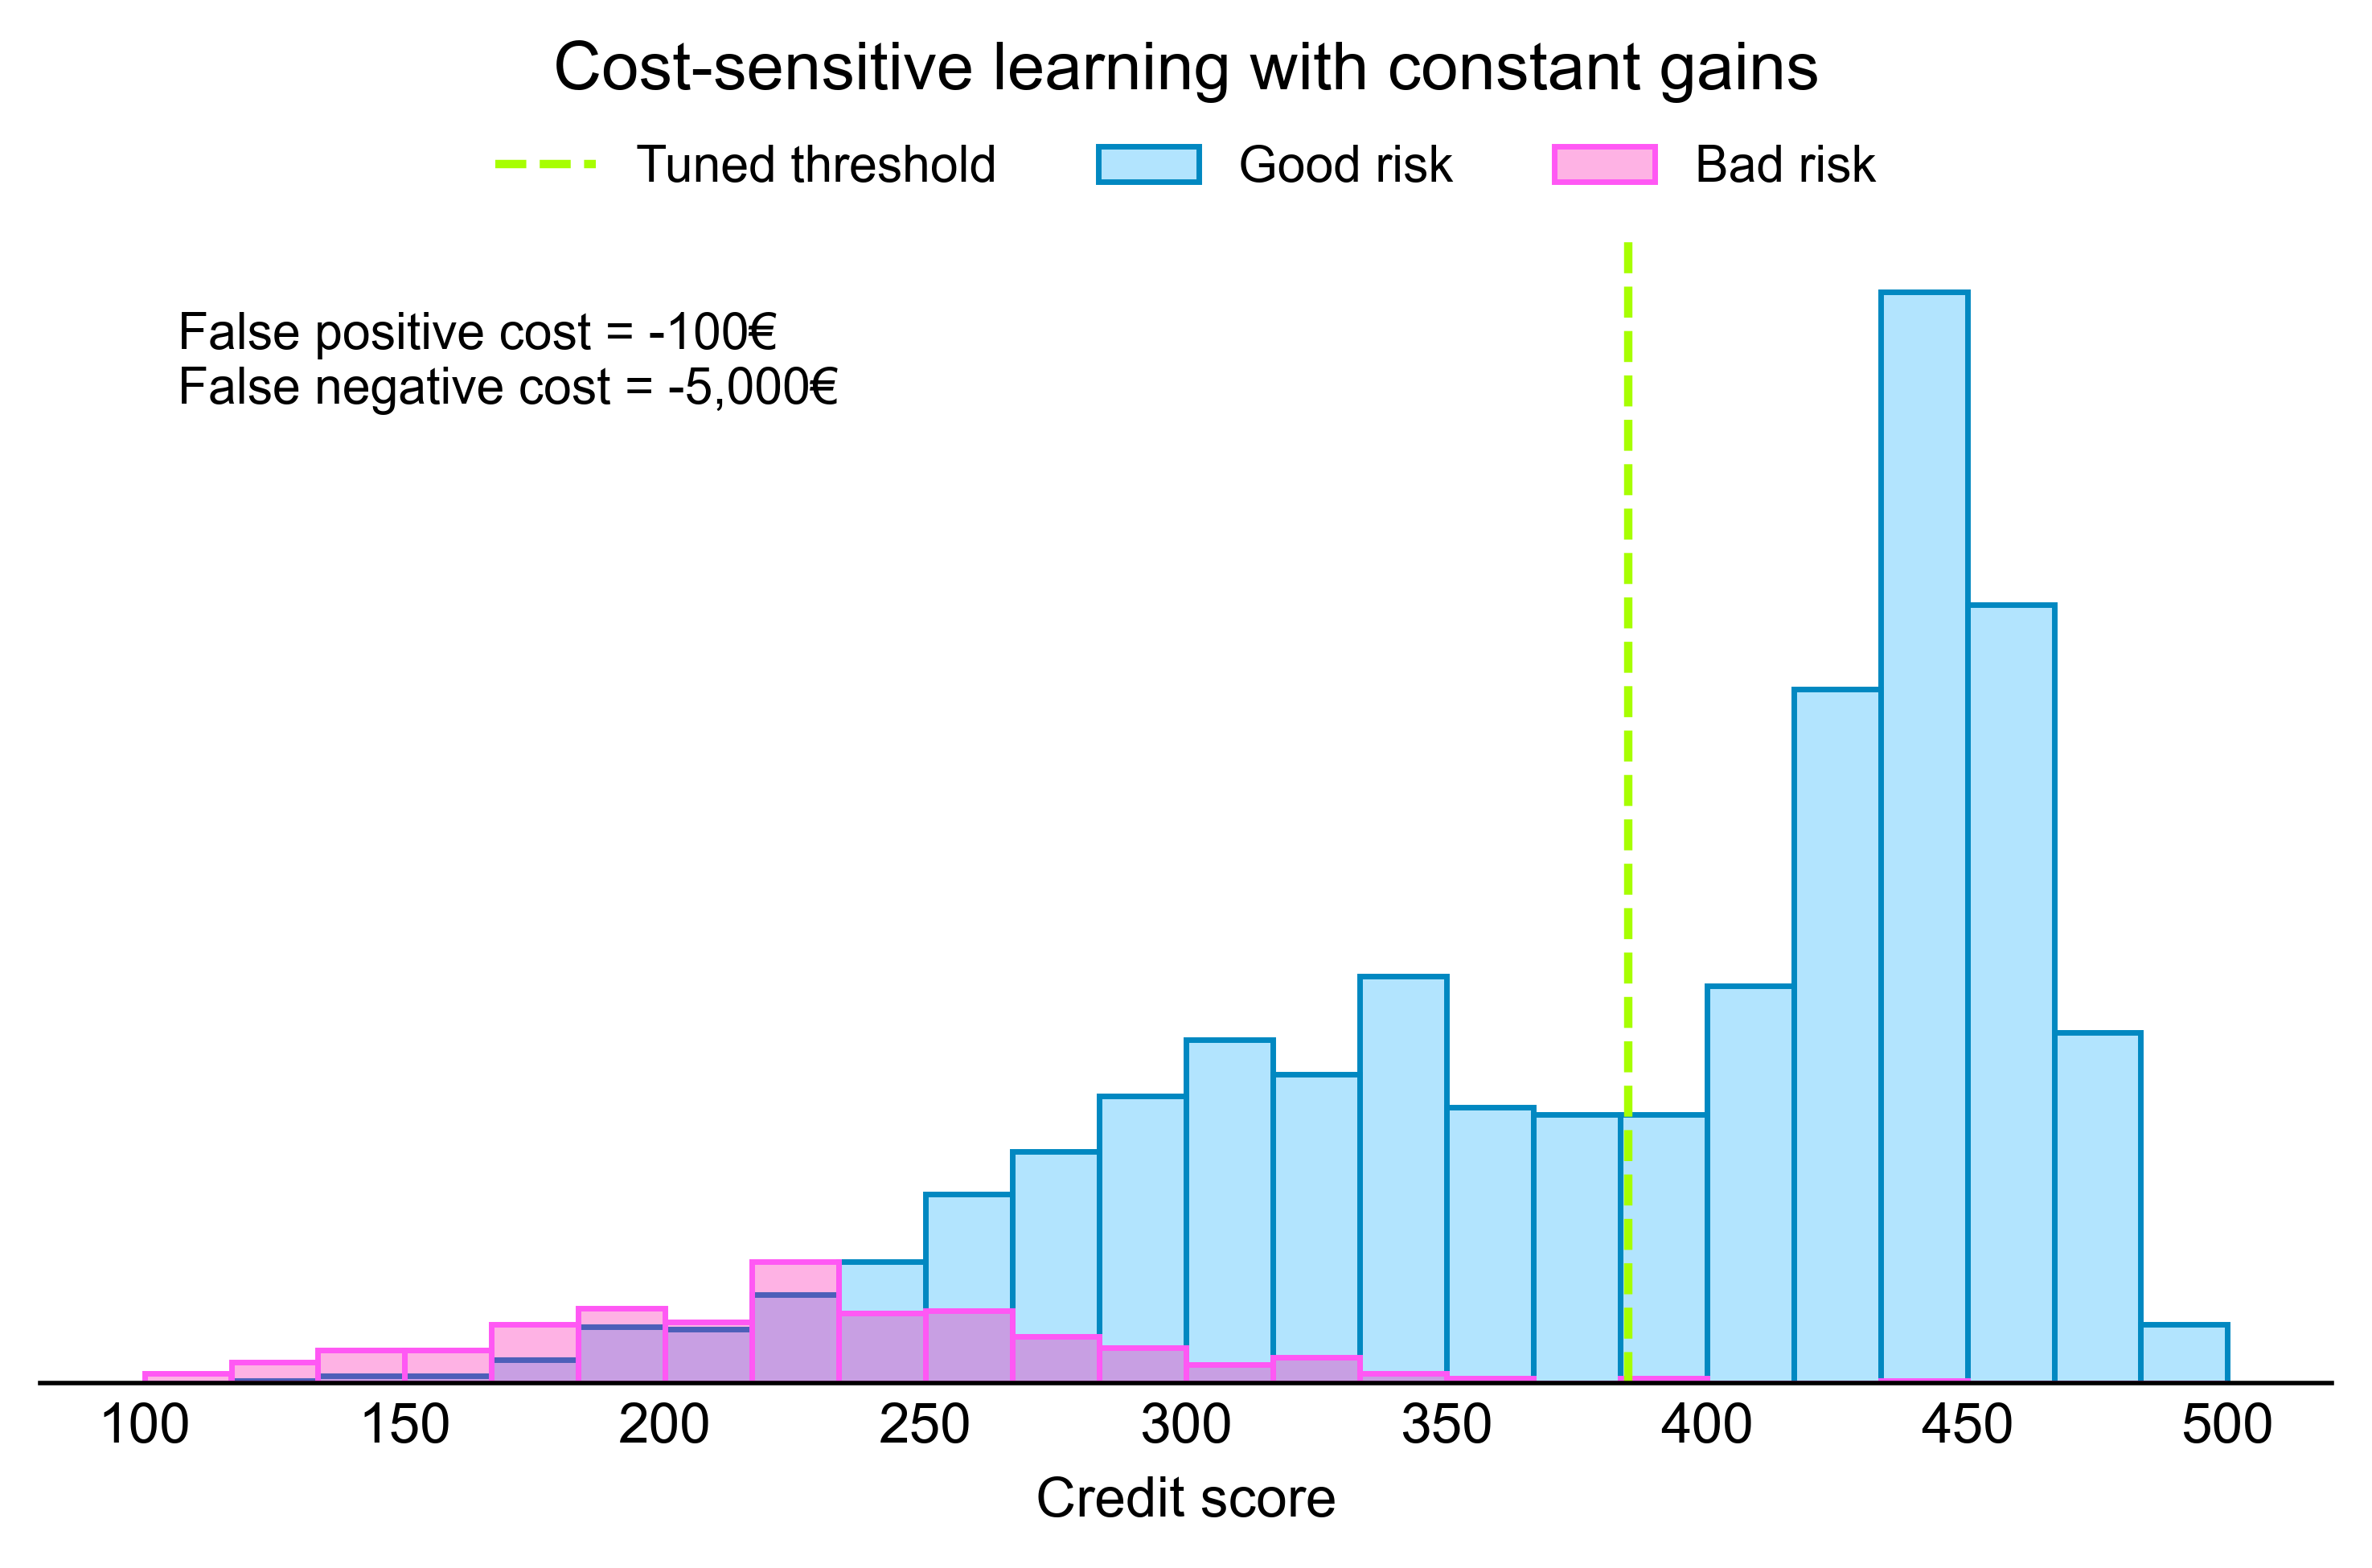

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

fn_values = np.linspace(-100, -5000)

gain_matrix = np.array(
    [
        [0, -100],  # gain for false positives
        [-100, 0],  # gain for false negatives
    ]
)

fig, ax = plt.subplots(figsize=(6, 4), dpi=500)
def update(frame):
    fn_value = frame
    gain_matrix[1][0] = fn_value
    plot_logit_histogram(model, X, y, ix_test, gain_matrix, bins=25, ax=ax)

ani = FuncAnimation(fig, update, frames=fn_values, repeat=True)
ani.save("constant_gains.gif", writer=PillowWriter(fps=3))  # type: ignore

plt.show()

## Non-constant gains

In [ ]:
def business_metric(y_true, y_pred, npv):
    """
    Calculates the business metric using true labels, predictions, and NPV values.

    Args:
        y_true (numpy.ndarray or pandas.Series): True labels.
        y_pred (numpy.ndarray or pandas.Series): Predicted labels.
        npv (numpy.ndarray or pandas.Series): Net present value for each observation.

    Returns:
        float: The calculated business metric.
    """
    mask_true_positive = (y_true == 1) & (y_pred == 1)
    mask_true_negative = (y_true == 0) & (y_pred == 0)
    mask_false_positive = (y_true == 0) & (y_pred == 1)
    mask_false_negative = (y_true == 1) & (y_pred == 0)

    # TP = loss, TN = profit, FP = profit lost, FN = loss incurred

    # Calculate NPV contributions
    true_positive_npv = -npv[mask_true_positive].sum()
    true_negative_npv = npv[mask_true_negative].sum()
    false_positive_npv = -npv[mask_false_positive].sum()
    false_negative_npv = npv[mask_false_negative].sum() / 0.25

    return (
       true_positive_npv
        + true_negative_npv
        + false_positive_npv
        + false_negative_npv
    ) / len(y_true)

In [ ]:
threshold_length = 50

### XGB

In [ ]:
import sklearn
from sklearn.metrics import get_scorer
from sklearn.metrics import make_scorer
from sklearn.model_selection import TunedThresholdClassifierCV

sklearn.set_config(enable_metadata_routing=True) # type: ignore
business_scorer = make_scorer(business_metric).set_score_request(npv=True)
balanced_accuracy_scorer = get_scorer("balanced_accuracy")

model = xgb.XGBClassifier(
    max_depth=4,
    n_estimators=100,
    learning_rate=0.1,
    min_child_weight=7,
    n_jobs=2,
    random_state=0
)

model.fit(X.loc[ix_train], y.loc[ix_train])

tuned_npv_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=business_scorer,
    thresholds=threshold_length,
    n_jobs=2,
    cv=10,
    store_cv_results=True,
)

tuned_npv_model.fit(X.loc[ix_train], y.loc[ix_train], npv=npv.loc[ix_train])

benefit_cost_xgb = business_scorer(tuned_npv_model, X.loc[ix_test], y.loc[ix_test], npv=npv.loc[ix_test])
bacc_xgb = balanced_accuracy_scorer(tuned_npv_model, X.loc[ix_test], y.loc[ix_test])

print(
    "Benefit/cost of our XGB logistic regression: "
    f"{benefit_cost_xgb:,.2f}€"
)

print(
    "bACC of our XGB logistic regression: "
    f"{bacc_xgb:.3f}"
)

print(tuned_npv_model.best_threshold_, tuned_npv_model.best_score_)

Benefit/cost of our XGB logistic regression: 22.51€
bACC of our XGB logistic regression: 0.857
0.060211361605645525 19.442020506060686


### Linear model

In [ ]:
from sklearn.linear_model import LogisticRegression

model_linear = LogisticRegression(
    C=0.05,
    max_iter=1000,
    n_jobs=2,
    random_state=0
)

model_linear.fit(X.loc[ix_train], y.loc[ix_train])

tuned_npv_model_linear = TunedThresholdClassifierCV(
    estimator=model_linear,
    scoring=business_scorer,
    thresholds=threshold_length,
    n_jobs=2,
    cv=10,
    store_cv_results=True,
)

tuned_npv_model_linear.fit(X.loc[ix_train], y.loc[ix_train], npv=npv.loc[ix_train])

benefit_cost_lin = business_scorer(tuned_npv_model_linear, X.loc[ix_test], y.loc[ix_test], npv=npv.loc[ix_test])
bacc_lin = balanced_accuracy_scorer(tuned_npv_model_linear, X.loc[ix_test], y.loc[ix_test])

print(
    "Benefit/cost of our linear model: "
    f"{benefit_cost_lin:,.2f}€"
)
print(
    "bACC of our linear model: "
    f"{bacc_lin:.3f}"
)

print(tuned_npv_model_linear.best_threshold_, tuned_npv_model_linear.best_score_)

Benefit/cost of our linear model: 17.70€
bACC of our linear model: 0.821
0.08188253379289691 15.781492493306786


### Animation for non-constant gains

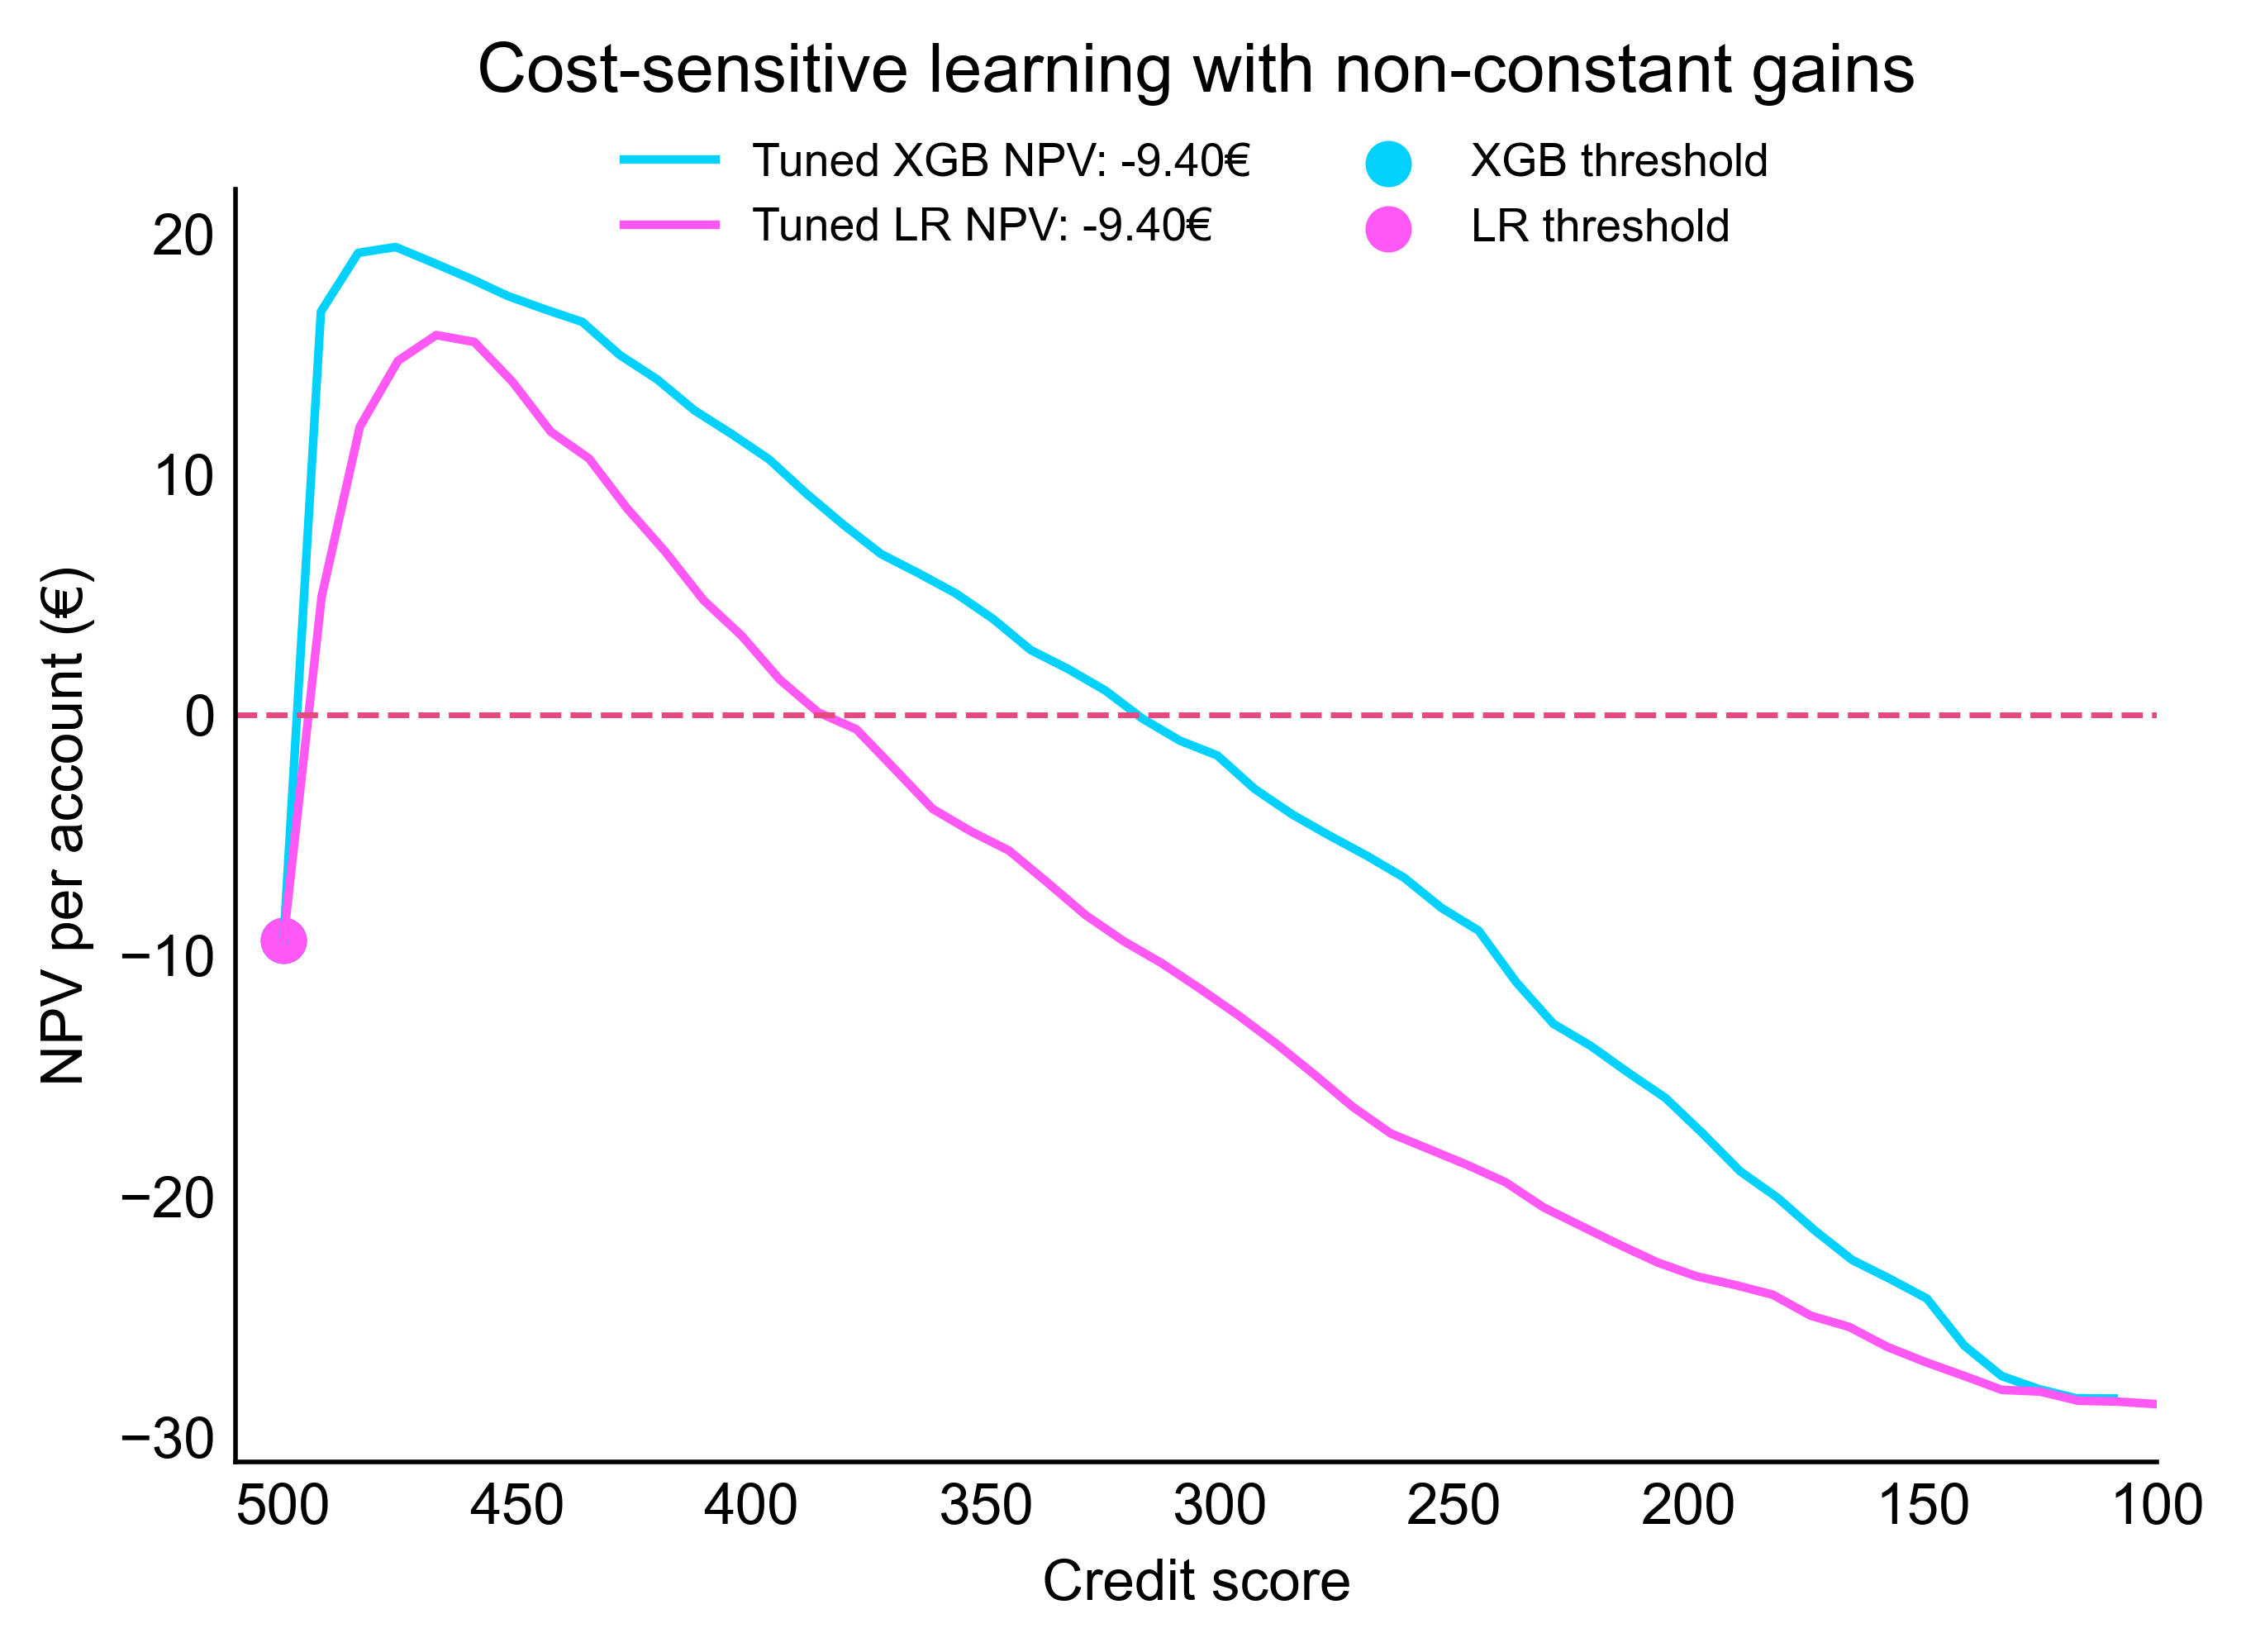

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# set font to Arial
plt.rcParams["font.sans-serif"] = "Arial"

cv_results = pd.DataFrame(tuned_npv_model.cv_results_)
cv_results_linear = pd.DataFrame(tuned_npv_model_linear.cv_results_)

thresholds = cv_results["thresholds"].values

# Define the function to transform thresholds to credit scores
def threshold_to_credit_score(threshold, score_min=100, score_max=500):
    return score_max - (score_max - score_min) * threshold  # Reverse the order

fig, ax = plt.subplots(figsize=(6, 4), dpi=500)

def update_plot(threshold_index):
    ax.clear()

    ax.tick_params(axis="x", length=0)
    ax.tick_params(axis="y", length=0)

    credit_score_xgb = threshold_to_credit_score(cv_results["thresholds"][threshold_index])
    credit_score_lr = threshold_to_credit_score(cv_results_linear["thresholds"][threshold_index])

    ax.plot(
        threshold_to_credit_score(cv_results["thresholds"]),
        cv_results["scores"],
        color="#02d1fe",
        label=f"Tuned XGB NPV: {cv_results['scores'][threshold_index]:.2f}€",
    )
    ax.plot(
        threshold_to_credit_score(cv_results_linear["thresholds"]),
        cv_results_linear["scores"],
        color="#ff58f4",
        label=f"Tuned LR NPV: {cv_results_linear['scores'][threshold_index]:.2f}€",
    )
    ax.axhline(0, color="#e64980", linestyle="--", linewidth=1)

    ax.scatter(
        credit_score_xgb,
        cv_results["scores"][threshold_index],
        color="#02d1fe",
        marker="o",
        s=50,
        label="XGB threshold",
    )
    ax.scatter(
        credit_score_lr,
        cv_results_linear["scores"][threshold_index],
        color="#ff58f4",
        marker="o",
        s=50,
        label="LR threshold",
    )

    ax.set_xlabel("Credit score")
    ax.set_ylabel("NPV per account (€)", color='black')
    ax.tick_params(axis="y", length=0, labelcolor='black')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlim(510, 100)

    ax.legend(
        loc="lower center",
        bbox_to_anchor=(0.5, 0.92),
        fancybox=True,
        shadow=False,
        ncol=2,
        fontsize=8,
        frameon=False,
    )
    ax.set_title('Cost-sensitive learning with non-constant gains', y=1.05)

ani = FuncAnimation(fig, update_plot, frames=len(thresholds), repeat=True)
ani.save("non_constant_gains.gif", writer=PillowWriter(fps=3))  # type: ignore

In [ ]:
np.trapz(cv_results["scores"]), np.trapz(cv_results_linear["scores"])

(-139.9227088857038, -492.0742105247457)